# Inference Speedup

## Seminar


### Plan

- Analyze the proof of distribution preservation in SpecDec + Sampling
- Create an introduction to Triton GeMM
  - General introduction, comparison with CUDA
  - Blocks/Threads vs Program
- Show execution times of GeMV, GeMM kernels and their scaling with batch size
  - Emphasize the execution time difference between DecodeMany vs Decode (DecodeMany == bs > 1. Almost no difference up to batch size 64 with Decode)
- Highlight how autotune affects performance during the decoding step


### SpecDec + Sampling

_Special thanks to Lesha Glikin._

Introduction:
- We consider one iteration of verification of a single draft token
- $V$ - set of all tokens
- $p$ - probability function of the target model token ($p: V \rightarrow [0,1]$)
- $q$ - probability function of the draft model token

Let's assume the token acceptance procedure works as follows:
- Sample token $t_q$ from $q$
- Based on the (stochastic!) acceptance procedure, decide whether to accept or reject $t_q$
- If rejected, sample a new token from the adjusted distribution of the target model (to be defined later)

**Formalization**:

- $t_q \sim q$ - token from the draft model
- $t_{\tilde p} \sim \tilde p $ - token from the adjusted distribution of the target model ($\tilde p$ is unknown yet)
- $r \sim R$ - source of randomness (unknown yet)
- $t_q ⫫ t_{\tilde p } ⫫ r$
- $t$ - the final token resulting from the verification step, defined as
  $$t = \begin{cases} t_q,\ A(t_q, r) \\ t_{\tilde p },\ \lnot A(t_q, r) \end{cases}$$
where $A(r, t_q)$ - the event of accepting/rejecting the token.

**Desirable properties:** we want to find such $\tilde p, A, R$ that:
- $t$ has the same distribution as $p$
    - because we want to preserve the distribution of the base model.
- $A(r, t_q)$ is maximized
    - because we want to maximize the probability of accepting the token.

Let's understand how the probability function $t$ works:

$$ P(t = T) = P(t = T \wedge A(t_q, r)) + P(t = T \wedge \lnot A(t_q, r)) $$


<details>
<summary>What is the first term equivalent to?</summary>

-  $t = T \wedge A(t_q, r)$
- Given that the token was accepted, $t = t_q$ (by definition of $t$), so in the left event we can substitute:
    -  $\iff t_q = T \wedge A(t_q, r)$
- Given that $t_q = T$, in the right event we can substitute it:
    - $\iff t_q = T \wedge A(T, r)$
- we now have a conjunction of independent events, therefore
    - $P(t_q = T \wedge A(T, r)) = q(T) \cdot P(A(T, r))$

</details>  

<details>
<summary>(The same more rigorously, for fans of sigma-algebras)</summary>

Consider a probability space $(\Omega, \mathcal{F}, P)$. All random variables $t, t_q, t_{\tilde p}, r, A$ are defined on it. $A(...)$ is a function that takes values 0 and 1.

- Consider all $\omega_0 \in \Omega$ such that 
    - $t(\omega_0) = T \wedge A(t_q(\omega_0), r(\omega_0)) = 1$.

- for all $\omega_0\colon A(t_q(\omega_0), r(\omega_0)) = 1$, we have $t(\omega_0) = t_q(\omega_0)$ -- simply by definition of $t$. Therefore, in the left event we can substitute:
    -  $\iff t_q(\omega_0) = T \wedge A(t_q(\omega_0), r(\omega_0)) = 1$
- on the other hand, for all $\omega_0$ it is additionally true that $\colon t(\omega_0) = T$. But this means that on this subset of omegas, $t_q$ is identically equal to $T$. Therefore, in the right event we can substitute:
    - $\iff t_q(\omega_0) = T \wedge A(T, r(\omega_0)) = 1$
- we now have a conjunction of independent events. Consequently, for all $\omega_0 \in \Omega$ such that $t(\omega_0) = T \wedge A(t_q(\omega_0), r(\omega_0)) = 1$, it holds that:
    - $P(t_q = T \wedge A(T, r)) = q(T) \cdot P(A(T, r))$

</details>  



<details>
<summary>What is the second term equivalent to?</summary>

-  $t = T \wedge \lnot A(t_q, r)$
- Since the token was not accepted, $t = t_{\tilde p}$ (again by definition of $t$), so we can substitute
    - $\iff t_{\tilde p} = T \wedge \lnot A(t_q, r)$
- we now have a conjunction of independent events
    - $P(t_{\tilde p} = T \wedge \lnot A(t_q, r)) = \tilde p(T) \cdot \left( 1 - P(A(t_q, r))\right)$

</details>



<details>
<summary>Overall, the token's probability can be written down as:</summary>

   $$P(t = T) = q(T) \cdot P(A(T, r)) + \tilde p(T) \cdot \left(1 - P(A(t_q, r))\right)$$

</details>


The requirement that $t \sim p$ is expressed as:
$$
\forall\ T \in V,\ p(t) = P(t = T)
$$

How do we now express $\tilde p(t)$?
<details>
<summary>Answer:</summary>

$$
\iff \forall\ T \in V,\ \tilde p (T) = \frac{p(T) - q(T) P(A(T, r))}{1 - P(A(t_q, r))}
= \frac{p(T) - q(T) \cdot P(A(T, r))}{\sum_{X \in V} \Bigl(p(X) - q(X) \cdot P(A(X, r))\Bigr)}
$$

</details>


This expression uniquely defines $\tilde p$ for fixed $A$ and $R$, and we only need the non-negativity of th numerators:
$$
p(T) - q(T) \cdot P(A(T, r)) \geq 0
$$
<details>
<summary>Which is equivalent to:</summary>

$$
\begin{align}
&P(A(T, r)) \leq \frac{p(T)}{q(T)}
\\
\iff &P(A(T, r)) \leq \min\left(1, \frac{p(T)}{q(T)}\right)
\end{align}
$$

</details>

How to choose $A, R$ so that the condition above is satisfied for all $T$, and to maximize $P(A(T, r))$?
<details>
<summary>Answer:</summary>

We can use $R = U[0, 1]$ and $A(T, r) = I\left(r < \frac{p(T)}{q(T)}\right)$.

Then let's write out what $\tilde p$ will be equal to:
$$
\tilde p (T) = \frac{p(T) - q(T) \cdot P(A(T, r))}{\sum_{X \in U} p(X) - q(X) \cdot P(A(X, r))}
= \frac{p(T) - q(T) \cdot \min \left(1, \frac{p(T)}{q(T)}\right)}{\ldots} = \frac{\max\left(p(T) - q(T), 0\right)}{\ldots}
$$
</details>

### Triton GeMM: a bit deeper.

#### Catch activation and weight

In [1]:
import time
from typing import List
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn

import triton
import triton.language as tl

print("torch version:", torch.__version__)
print("triton version:", triton.__version__)

from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

torch version: 2.5.1+cu124
triton version: 3.1.0


In [2]:
model_name = "Qwen/Qwen2.5-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
streamer = TextStreamer(tokenizer, skip_prompt=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# challenging input
prompt = """
# SYSTEM PREAMBLE
1) You are an excellent Python software developer with over 10 years of experience. You have a strong understanding of Python related topics, data structures, libraries, frameworks, algorithms, best practices and optimization techniques.
2) You are here to help the user (the software developer) by breaking his request in ## TASK into logical steps and writing high-quality and efficient code to implement each step.
3) You have to return the entire code.
4) Follow "Answering rules" without exception.

## ANSWERING RULES
1) Repeat the question before answering it.
2) Always follow "CHAIN OF THOUGHTS" to execute the task.

## CHAIN OF THOUGHTS
1) **OBEY the EXECUTION MODE**
2) **TASK ANALYSIS:**
   - Understand the user's request thoroughly.
   - Identify the key components and requirements of the task.
3) **PLANNING: CODDING:**
   - Break down the task into logical, sequential steps.
   - Outline the strategy for implementing each step.
4) **CODING:**
   - Explain your thought process before writing any code.
   - Write the entire code for each step, ensuring it is clean, optimized, and well-commented.
   - Handle edge cases and errors appropriately.
5) **VERIFICATION:**
   - Review the complete code solution for accuracy and efficiency.
   - Ensure the code meets all requirements and is free of errors.

## TASK

Write a python function that receives the following JSON as input and enters data from it into the Google Sheet.

{
    'date': '31-05-2024',
    'revenue': 90000,
    'person' : 'User1',
    'expensesList': [30000, 14000, 10000, 2000, 15000],
    'expensesDescList': [ 'Ключи', 'Ключи2', 'Счет за такси', 'Клей, пластины', 'Провод 40м'],
    'expensesTypeList': ['Закупки', 'Закупки', 'Расходы', 'Ремонт', 'Ремонт']
}

There is a date in JSON, you can use it to determine the month.
The data is entered into a list with the name of the month. If such a list does not exist yet, then you need to create a list with a new month inside the sheet.

The list should have the following columns (the first rows are used as headings):
A1: Дата расхода,
B1: сумма расхода,
C1: описание расхода,
D1: тип расхода,
E1: кто внес данные

G1: Дата выручки
H1: Сумма выручки
I1: Кто внес данные

Please separate expenses and profits with a blank column.
Please sort expenses by date, including those already listed in Google sheet list.
Please sort earnings by date, including those already listed in Google sheet list.

It is prohibited to use oauth2client as it is deprecated.
"""

In [4]:
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
generation_output = model.generate(**model_inputs, streamer=streamer, max_new_tokens=1024)

To accomplish the task, we will follow these steps:

1. Parse the JSON data.
2. Create or update the expense and profit lists in the Google Sheet.
3. Sort both lists by date.
4. Insert the data into the appropriate columns in the Google Sheet.

Let's start by parsing the JSON data and creating the necessary lists. For simplicity, we will assume that the Google Sheet has been set up correctly and that we have access to the necessary Google Sheets API client library. We'll use `google-auth` and `google-api-python-client` for authentication and interaction with the Google Sheets API.

Here's the complete code:

```python
import json
from datetime import datetime
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build

def parse_json(json_data):
    """Parse the JSON data."""
    parsed_data = json.loads(json_data)
    
    # Extract relevant information
    date_str = parsed_data['date']
    revenue = parsed_data['revenue']
    person = parsed_data['p

In [ ]:
class Catcher(nn.Module):
    def __init__(self, inps: List, module: nn.Module):
        """Use this module to wrap model layer to save its inputs.

        Args:
            inps (List): external inputs storage
            module (nn.Module): module to wrap
        """
        super().__init__()
        
        # YOUR CODE HERE
        ...
        

    def forward(self, inp, **kwargs):
        """Save inps to storage and raise an exception ValueError

        Args:
            inp: inputs to save
        """
        # YOUR CODE HERE
        ...

In [7]:
layer = model.model.layers[0]
inps = []
layer.self_attn.q_proj = Catcher(inps, layer.self_attn.q_proj) # wrap

In [8]:
try:
    model(model_inputs.input_ids)
except ValueError as e:
    layer.self_attn.q_proj = layer.self_attn.q_proj.module

In [9]:
inps[0].shape

torch.Size([1, 700, 2048])

In [10]:
# unwrap
weight = layer.self_attn.q_proj.weight

### Triton GeMM

#### When to Use Triton
- Optimization Steps:
1. Use torch.compile():
    - Start by using torch.compile() to optimize your code.
2. Adapt Your Code:
    - Rewrite code to be more suitable for torch.compile().
        - E.g., eliminate graph breaks to enable CUDA graphs.
3. Profile and Identify Bottlenecks:
    - Find slow parts of your code using profiling tools.
    - Write custom Triton kernels for these parts.
4. Consider CUDA:
    - If still not fast enough, write custom CUDA kernels.

**Note**: For maximum performance from the start, you may choose CUDA directly.

#### Rough Edges in Triton
- New-ish Project:
    - Contains rough edges; code may not behave as expected.
    - Expected to become more polished over time.
- Recommendation:
    - Debugging is important; use “simulator mode” when possible.
    - Be aware of limitations on older GPUs or with certain operations.

Resources (most useful):
- [GPU MODE Lecture 14: Practitioners Guide to Triton](https://christianjmills.com/posts/cuda-mode-notes/lecture-014/#auto-tuning) - contains basic description of Triton development, its pros/cons, practical examples with full explanations, and optimization techniques
- [Flash-Decoding for long-context inference](https://pytorch.org/blog/flash-decoding/) - description of SPLIT_K optimization for faster inference during the decoding step by better utilizing the GPU

Less useful but interesting:
- [Deep Dive on the Hopper TMA Unit for FP8 GEMMs](https://pytorch.org/blog/hopper-tma-unit/) - about the importance of TMA unit for Hopper and BlackWell
- [Persistent Matmul](https://triton-lang.org/main/getting-started/tutorials/09-persistent-matmul.html) - special version of GeMM for Hopper and BlackWell with TMA support


In [11]:
def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"

assert is_cuda(), "CUDA only tutorial"
ref_lib = 'cuBLAS'

In [12]:
# TODO: play  with configs on seminar
def get_cuda_autotune_config():
    return [
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        # custom
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    raise NotImplementedError("ooops")

In [13]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b, allow_tf32=False)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = accumulator.to(c_ptr.dtype.element_ty)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)

In [14]:
def matmul(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c

Sanity check on quality:

In [15]:
torch.manual_seed(0)

a = inps[0][0].to(torch.float16).cuda()
b = weight.to(torch.float16).cuda()

triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)

if torch.allclose(triton_output, torch_output, atol=2e-2):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")
    print(f"triton_output_with_fp16_inputs={triton_output}")
    print(f"torch_output_with_fp16_inputs={torch_output}")
    assert False, "Check quality"

✅ Triton and Torch match


In [16]:
seqlen = inps[0].shape[1]
hidden_size = inps[0].shape[2]
seqlen, hidden_size


def prepare_a(M: int):
    inp = inps[0][0]
    if M > seqlen:
        n_repeats = M // seqlen + 1
        return inp.repeat(n_repeats, 1)[:M]
    else:
        return inp[:M]


def benchmark(M, provider, provider_funcs):
    N = weight.shape[0]
    K = weight.shape[1]

    a = prepare_a(M).to(torch.float16).cuda()
    b = weight.T.to(torch.float16)
    assert a.shape == (M, K), f"{a.shape} != {(M, K)}"
    assert b.shape == (K, N), b.shape

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: provider_funcs[provider](a, b), quantiles=quantiles)
    perf = lambda ms: ms # TFlops = 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


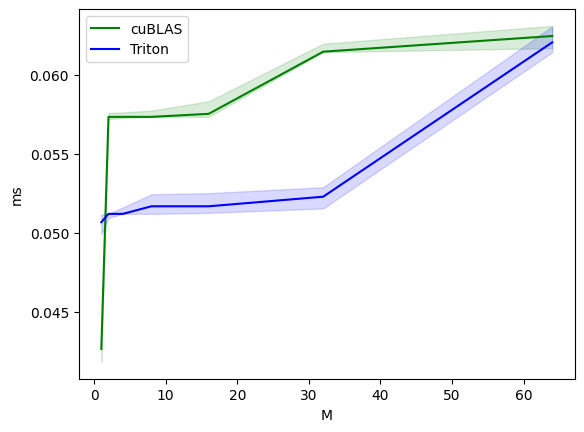

GeMV-performance-fp16:
      M    cuBLAS    Triton
0   1.0  0.042640  0.050672
1   2.0  0.057344  0.051200
2   4.0  0.057344  0.051200
3   8.0  0.057344  0.051680
4  16.0  0.057536  0.051680
5  32.0  0.061472  0.052288
6  64.0  0.062464  0.062064


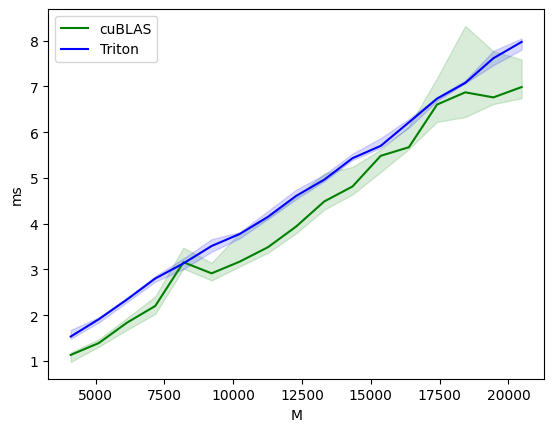

GeMM-performance-fp16:
          M    cuBLAS    Triton
0    4096.0  1.134592  1.535680
1    5120.0  1.394688  1.914752
2    6144.0  1.840192  2.346016
3    7168.0  2.203040  2.803680
4    8192.0  3.158048  3.133008
5    9216.0  2.916320  3.512736
6   10240.0  3.172768  3.776800
7   11264.0  3.486976  4.150928
8   12288.0  3.938800  4.607584
9   13312.0  4.487152  4.963056
10  14336.0  4.813248  5.431008
11  15360.0  5.482304  5.699728
12  16384.0  5.670224  6.212784
13  17408.0  6.602560  6.731712
14  18432.0  6.869008  7.074528
15  19456.0  6.758400  7.614688
16  20480.0  6.984048  7.969312


In [17]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[2 ** i for i in range(7)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMV-performance-" + ("fp16"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": {"triton": matmul, "cublas": torch.matmul}},
    ),
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(4, 21)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMM-performance-" + ("fp16"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": {"triton": matmul, "cublas": torch.matmul}},
    ),
]


triton.testing.perf_report(configs)(benchmark).run(show_plots=True, print_data=True)

**Not bad!!!**